# XAI(Explainable AI): Kernel SHAP for Classification

본 핸즈온에서는 앙상블과 같은 블랙 박스 모델을 설명하는 데 적합한 SHAP(SHapley Additive exPlanations)을 사용하는 예시를 보여줍니다. SHAP은 전체 셋의 feature importance가 아니라 각 샘플 데이터마다 예측에 얼마나 기여했는지 정량화가 가능합니다.

## SHAP(SHapley Additive exPlanations)

SHAP에 대한 심화 주제는 아래 논문과 링크를 참조하세요
- [A Unified Approach to Interpreting Model Predictions] Lundberg, Scott M., and Su-In Lee Advances in Neural Information Processing Systems. 2017.
- Interpretable ML Book (SHAP chapter): http://christophm.github.io/interpretable-ml-book/shap.html

In [1]:
%load_ext autoreload
%autoreload 2
!pip install -qU shap

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
import sklearn
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

<br>

## 1. Data preparation and Training

In [3]:
N_SUBSAMPLE = 500  # subsample datasets for faster demo
N_TEST = 50
NSHAP_SAMPLES = 10  # how many samples to use to approximate each Shapely value, larger values will be slower

train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')  # can be local CSV file as well, returns Pandas DataFrame
train_data = train_data.sample(N_SUBSAMPLE)
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')
test_data = test_data.sample(N_TEST)

label = 'class'

y_train = train_data[label]
y_test = test_data[label]
X_train = pd.DataFrame(train_data.drop(columns=[label]))
X_test = pd.DataFrame(test_data.drop(columns=[label]))

display(train_data.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
26802,55,Self-emp-not-inc,319883,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,4386,0,10,?,>50K
19134,78,?,167336,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,16,United-States,<=50K
37431,36,Private,190350,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K
20173,25,Self-emp-inc,160261,Bachelors,13,Never-married,Exec-managerial,Own-child,Asian-Pac-Islander,Male,0,0,35,Taiwan,<=50K
3869,47,Private,216096,Some-college,10,Married-spouse-absent,Exec-managerial,Unmarried,White,Female,0,0,35,Puerto-Rico,<=50K


In [4]:
save_path = 'ag-03-explainable-ai'
!rm -rf $save_path

In [5]:
predictor = TabularPredictor(label=label, path=save_path, problem_type='binary').fit(train_data, time_limit=20)

Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to "ag-03-explainable-ai/"
AutoGluon Version:  0.5.2
Python Version:     3.8.12
Operating System:   Linux
Train Data Rows:    500
Train Data Columns: 14
Label Column: class
Preprocessing data ...
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative ( <=50K) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11886.91 MB
	Train Data (Original)  Memory Usage: 0.29 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeat

<br>

## 2. Explain predictions

SHAP은 각 피쳐가 예측 결과에 "얼마나" 기여하는지 설명합니다. 구체적으로 baseline에서 positive 클래스의 예측 확률 간의 편차로 정량화되며,
신규 데이터에 대한 예측 시에는 훈련 데이터에 대한 평균 예측과 다른 각 피쳐가 예측에 얼마나 기여하는지 정량화합니다.

In [6]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict_proba(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict_proba(X)

피쳐의 baseline reference 값을 정의합니다. 

In [7]:
baseline = X_train.sample(100) # X_train.mode() could also be reasonable baseline for both numerical/categorical features rather than an entire dataset.

AutoGluon 예측 결과를 설명하기 위해 Kernel SHAP 값을 반환하는 KernelExplainer를 생성합니다.

In [8]:
ag_wrapper = AutogluonWrapper(predictor, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)
print("Baseline prediction: ", np.mean(ag_wrapper.predict_proba(baseline)))  # this is the same as explainer.expected_value

Baseline prediction:   <=50K    0.582965
 >50K     0.417035
dtype: float64


### SHAP for single datapoint

훈련 데이터셋 내의 임의의 데이터 포인트에 대해 SHAP을 plot해 보겠습니다.

In [9]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_proba(single_datapoint)
shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
shap.force_plot(explainer.expected_value[0], shap_values_single[0], X_train.iloc[ROW_INDEX,:])

In [11]:
shap.force_plot(explainer.expected_value[1], shap_values_single[1], X_train.iloc[ROW_INDEX,:])

### SHAP for dataset

테스트 데이터셋의 모든 데이터 포인트에 대해서도 SHAP을 plot할 수 있습니다.

In [12]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

  0%|          | 0/50 [00:00<?, ?it/s]

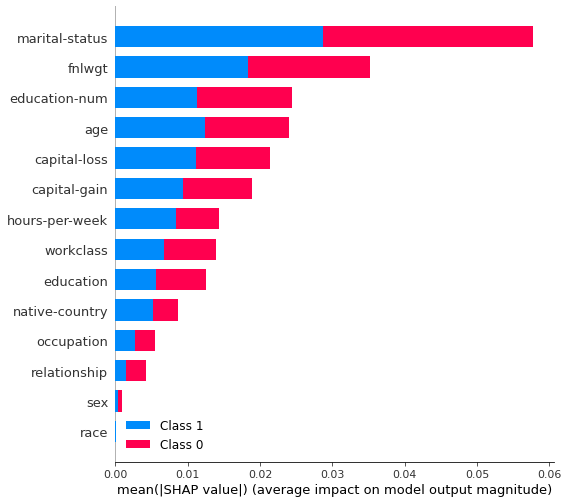

In [13]:
shap.summary_plot(shap_values, X_test)

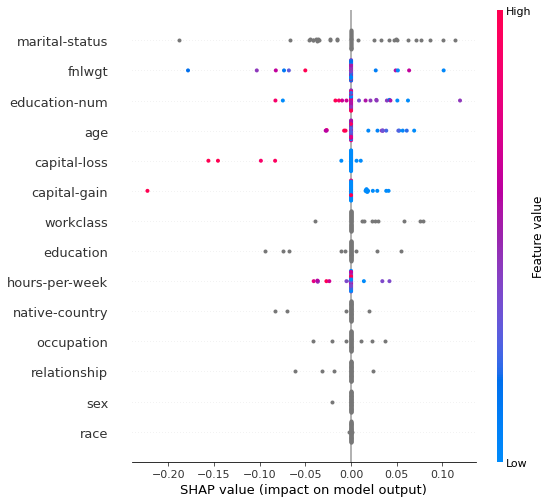

In [14]:
shap.summary_plot(shap_values[0], X_test)

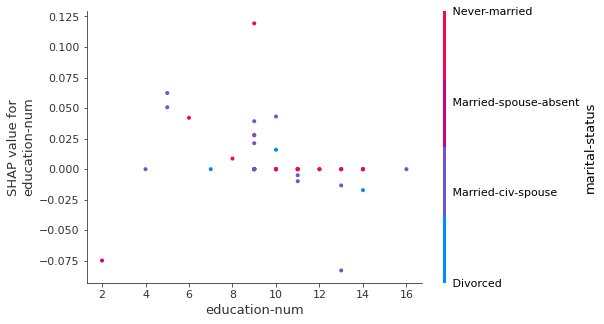

In [15]:
shap.dependence_plot("education-num", shap_values[0], X_test)

### Overall Feature Importance 

개별 예측을 설명하는 대신 각 피쳐가 AutoGluon의 일반적인 예측 정확도에 얼마나 기여하는지 알고 싶다면 Permutation Shuffling을 활용할 수 있습니다.

In [16]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 14 features using 50 rows with 5 shuffle sets...
	7.3s	= Expected runtime (1.46s per shuffle set)
	0.87s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
marital-status,0.064,0.029665,0.004249,5,0.125080,0.002920
education-num,0.048,0.017889,0.001941,5,0.084833,0.011167
capital-gain,0.032,0.017889,0.008065,5,0.068833,-0.004833
capital-loss,0.024,0.026077,0.054350,5,0.077693,-0.029693
age,0.004,0.043359,0.423322,5,0.093277,-0.085277
relationship,0.004,0.016733,0.310654,5,0.038454,-0.030454
workclass,0.000,0.000000,0.500000,5,0.000000,0.000000
education,0.000,0.000000,0.500000,5,0.000000,0.000000
race,0.000,0.000000,0.500000,5,0.000000,0.000000
native-country,0.000,0.000000,0.500000,5,0.000000,0.000000


<br>

## 3. Multiclass Classification
다중(multi) 클래스 분류도 SHAP 적용이 가능합니다. 이번에는 개인 소득 대신 가족 관계(relationshop)를 예측하는 문제로 변경해서 훈련을 수행 후 SHAP을 확인해 보겠습니다.

In [17]:
label = 'relationship'

y_train = train_data[label]
y_test = test_data[label]
X_train = pd.DataFrame(train_data.drop(columns=[label]))
X_test = pd.DataFrame(test_data.drop(columns=[label]))

display(train_data.head())
print("Possible classes: \n", train_data[label].value_counts())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
26802,55,Self-emp-not-inc,319883,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,4386,0,10,?,>50K
19134,78,?,167336,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,16,United-States,<=50K
37431,36,Private,190350,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K
20173,25,Self-emp-inc,160261,Bachelors,13,Never-married,Exec-managerial,Own-child,Asian-Pac-Islander,Male,0,0,35,Taiwan,<=50K
3869,47,Private,216096,Some-college,10,Married-spouse-absent,Exec-managerial,Unmarried,White,Female,0,0,35,Puerto-Rico,<=50K


Possible classes: 
  Husband           234
 Not-in-family     114
 Own-child          78
 Unmarried          49
 Wife               15
 Other-relative     10
Name: relationship, dtype: int64


`problem_type`을 지정하지 않아도 AutoGluon에서 자동으로 처리하지만, 안전하게 `problem_type=multiclass`로 지정합니다.

In [18]:
save_path = 'ag-03-explainable-ai-multiclass'
!rm -rf $save_path

In [19]:
predictor_multi = TabularPredictor(label=label, path=save_path, problem_type='multiclass').fit(train_data, time_limit=20)

Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to "ag-03-explainable-ai-multiclass/"
AutoGluon Version:  0.5.2
Python Version:     3.8.12
Operating System:   Linux
Train Data Rows:    500
Train Data Columns: 14
Label Column: relationship
Preprocessing data ...
Train Data Class Count: 6
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    13576.74 MB
	Train Data (Original)  Memory Usage: 0.29 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimiz

In [20]:
baseline = X_train.sample(100) # X_train.mode() could also be reasonable baseline for both numerical/categorical features rather than an entire dataset.

ag_wrapper = AutogluonWrapper(predictor_multi, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)

In [21]:
pd.DataFrame(np.mean(ag_wrapper.predict_proba(baseline),axis=0))

,0
Husband,0.491491
Not-in-family,0.213104
Other-relative,0.011575
Own-child,0.191880
Unmarried,0.072857
Wife,0.019095


In [22]:
print("Class Info: \n", predictor_multi.class_labels)

NSHAP_SAMPLES = 10  # how many samples to use to approximate each Shapely value, larger values will be slower
shap.initjs()

Class Info: 
 [' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife']


class 중 Not-in-family에 대해서 SHAP을 plot해 보겠습니다.

In [23]:
ROW_INDEX = 0  # index of an example datapoint
class_of_interest = ' Not-in-family'  # can be any value in set(y_train)
class_index = predictor_multi.class_labels.index(class_of_interest)

single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_proba(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
print("Shapely values: \n", {predictor_multi.class_labels[i]:shap_values_single[i] for i in range(len(predictor_multi.class_labels))})

print(f"Force_plot for class: {class_of_interest}")
shap.force_plot(explainer.expected_value[class_index], shap_values_single[class_index], X_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

Shapely values: 
 {' Husband': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.38148441, 0.        , 0.        , 0.09544831, 0.        ,
        0.        , 0.        , 0.        , 0.        ]]), ' Not-in-family': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.20806026,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]]), ' Other-relative': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.00548243,  0.        ,  0.        , -0.00209195,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]]), ' Own-child': array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        -0.1856742,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ]]), ' Unmarried': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.05492021,  0

In [24]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES)

print(f"Force_plot for class: {class_of_interest}")
shap.force_plot(explainer.expected_value[class_index], shap_values[class_index], X_test)

  0%|          | 0/50 [00:00<?, ?it/s]

Force_plot for class:  Not-in-family


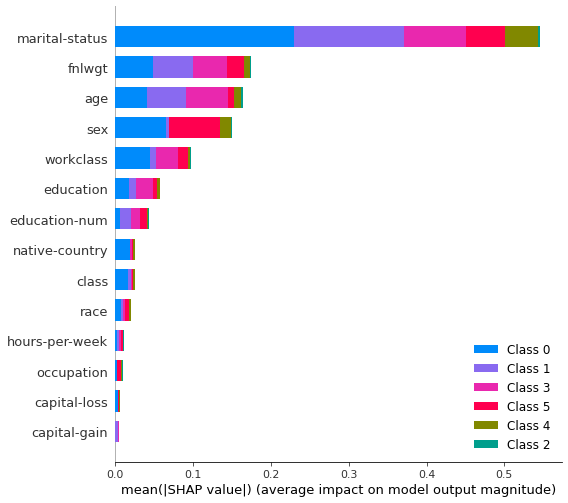

{'Class 0': ' Husband', 'Class 1': ' Not-in-family', 'Class 2': ' Other-relative', 'Class 3': ' Own-child', 'Class 4': ' Unmarried', 'Class 5': ' Wife'}


In [25]:
shap.summary_plot(shap_values, X_test)
print({"Class "+str(i) : predictor_multi.class_labels[i] for i in range(len(predictor_multi.class_labels))})

Dependence_plot for class:  Not-in-family  and for feature: marital-status 



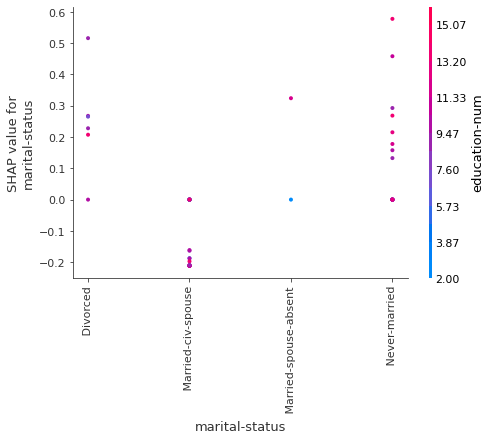

In [26]:
dependence_feature = "marital-status"
print(f"Dependence_plot for class: {class_of_interest}  and for feature: {dependence_feature} \n")

shap.dependence_plot(dependence_feature, shap_values[class_index], X_test)

In [27]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 14 features using 50 rows with 5 shuffle sets...
	7.57s	= Expected runtime (1.51s per shuffle set)
	0.87s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
marital-status,0.064,0.029665,0.004249,5,0.125080,0.002920
education-num,0.048,0.017889,0.001941,5,0.084833,0.011167
capital-gain,0.032,0.017889,0.008065,5,0.068833,-0.004833
capital-loss,0.024,0.026077,0.054350,5,0.077693,-0.029693
age,0.004,0.043359,0.423322,5,0.093277,-0.085277
relationship,0.004,0.016733,0.310654,5,0.038454,-0.030454
workclass,0.000,0.000000,0.500000,5,0.000000,0.000000
education,0.000,0.000000,0.500000,5,0.000000,0.000000
race,0.000,0.000000,0.500000,5,0.000000,0.000000
native-country,0.000,0.000000,0.500000,5,0.000000,0.000000
